In [1]:
%matplotlib inline
import sys
sys.path.append("src") # add the source dir

In [2]:
import matplotlib.pyplot as plt
import os
from src.pipeline import Pipeline, MultiPipeline
from mne_bids import BIDSPath
import mne

## We will do an individual Analysis of subject 30, afterthat, we will statistically check all the other subject

In [3]:
bids_root = os.path.join('data', 'P3')
bids_path = BIDSPath(subject='030', session='P3', task='P3',datatype='eeg', suffix='eeg', root=bids_root)
pipeline = Pipeline(bids_path)

In [4]:
from preprocessing import CleaningData, SimpleMNEFilter, PrecomputedICA

pipeline.load_data()
pipeline.set_montage()
pipeline.set_custom_events_mapping(task='P3')

INFO:root:Loading Data
INFO:root:Standard 1020 montage and EOG channels are set


### We will use our pipeline to perform following operations
- Loading bad segments, bad channels
- Apply filtering
- Loading Precomputed ICA

In [5]:
pipeline.make_pipeline([SimpleMNEFilter(1., 50, 'firwin'), CleaningData(bids_path), PrecomputedICA(bids_path)])

INFO:root:*****Proceesing for subject: 030*****
INFO:root:Applying filtering
INFO:root:Applying cleaning
INFO:root:Applying ICA
INFO:root:Processed subject 030



In [6]:
pipeline.apply_rereferencing('average')
pipeline.apply_resampling(512)

INFO:root:Applying re-referencing
INFO:root:Applying resampling


# ERP Peak Analysis

In [7]:
from erpanalysis import ERPAnalysis
tmin = -0.1
tmax = 0.8
baseline = (None, 0)


## We will create epochs from custom mappings, where,

- Stimulus: A, B, C, D, E

- Conditions: Rare, Frequent

In [8]:
erp = ERPAnalysis(tmin, tmax)
erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, baseline=baseline, reject_by_annotation=True)

<Epochs |  402 events (good & bad), -0.0996094 - 0.800781 sec, baseline -0.0996094 – 0 sec, ~49 kB, data not loaded,
 'response/correct/201': 193
 'response/error/202': 9
 'stimulus/A/freq/12': 4
 'stimulus/A/freq/13': 10
 'stimulus/A/freq/14': 9
 'stimulus/A/freq/15': 9
 'stimulus/A/rare/11': 8
 'stimulus/B/freq/21': 6
 'stimulus/B/freq/23': 12
 'stimulus/B/freq/24': 3
 'stimulus/B/freq/25': 11
 'stimulus/B/rare/22': 8
 'stimulus/C/freq/31': 8
 'stimulus/C/freq/32': 10
 'stimulus/C/freq/34': 4
 'stimulus/C/freq/35': 10
 'stimulus/C/rare/33': 8
 'stimulus/D/freq/41': 7
 'stimulus/D/freq/42': 12
 'stimulus/D/freq/43': 11
 'stimulus/D/freq/45': 2
 'stimulus/D/rare/44': 8
 'stimulus/E/freq/51': 8
 'stimulus/E/freq/52': 12
 'stimulus/E/freq/53': 4
 'stimulus/E/freq/54': 8
 'stimulus/E/rare/55': 8>

## Analysis Epochs

In [9]:
rare_epochs = erp.epochs['rare']
freq_epochs = erp.epochs['freq']

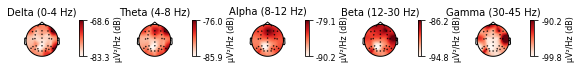

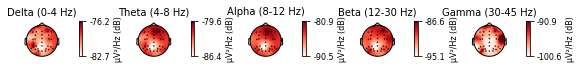

In [10]:
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
rare_epochs.plot_psd_topomap(axes = axs);
_, axs = plt.subplots(nrows=1, ncols=5, figsize=(8, 4));
freq_epochs.plot_psd_topomap(axes = axs);

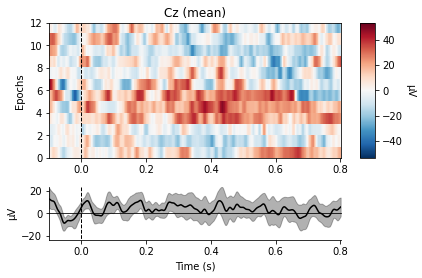

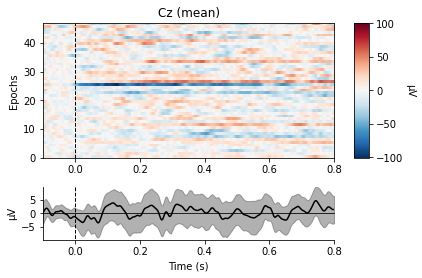

In [11]:
rare_epochs.plot_image(picks=['Cz'], combine='mean');
freq_epochs.plot_image(picks=['Cz'], combine='mean');

## Analysis Evokeds

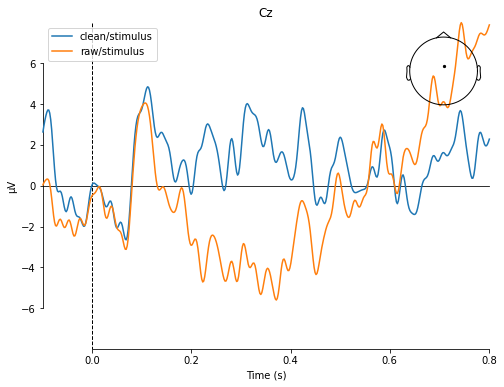

[<Figure size 576x432 with 2 Axes>]

In [12]:
epochs_raw = erp.compute_epochs(pipeline.raw, pipeline.events, pipeline.event_ids, set_default=False, reject_by_annotation=False)
epochs_clean = erp.epochs.copy()
evoked_raw = epochs_raw['stimulus'].average()
evoked_clean = epochs_clean['stimulus'].average()
mne.viz.plot_compare_evokeds({'clean/stimulus': evoked_clean,'raw/stimulus': evoked_raw}, picks="Cz")

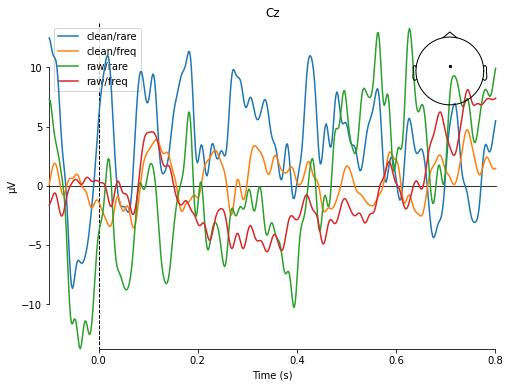

[<Figure size 576x432 with 2 Axes>]

In [13]:
mne.viz.plot_compare_evokeds({'clean/rare': epochs_clean['rare'].average(),
'clean/freq': epochs_clean['freq'].average(),
'raw/rare':epochs_raw['rare'].average(),
'raw/freq': epochs_raw['freq'].average(),
},picks="Cz")

In [14]:
evoked_rare = epochs_clean['rare'].average()
evoked_freq = epochs_clean['freq'].average()

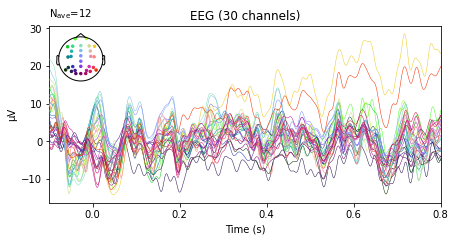

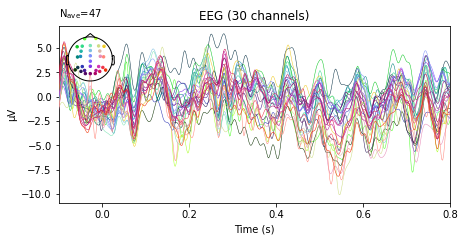

In [15]:
evoked_rare.plot(spatial_colors=True);
evoked_freq.plot(spatial_colors=True);

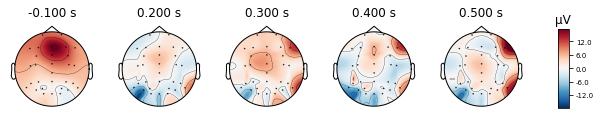

In [16]:
evoked_rare.plot_topomap(times=[-0.1, 0.2, 0.3, 0.4, 0.5], average=0.05);

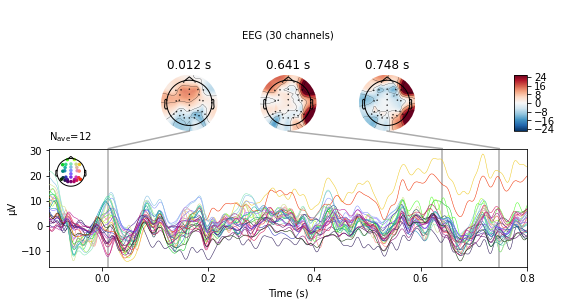

In [17]:
evoked_rare.plot_joint();

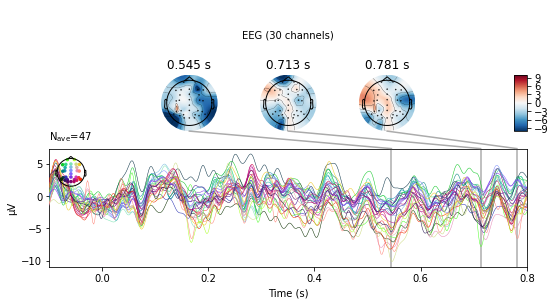

In [18]:
evoked_freq.plot_joint();

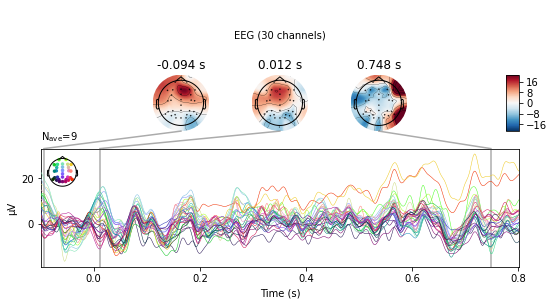

In [19]:
rare_minus_freq = mne.combine_evoked([evoked_rare, evoked_freq], weights=[1, -1])
rare_minus_freq.plot_joint();

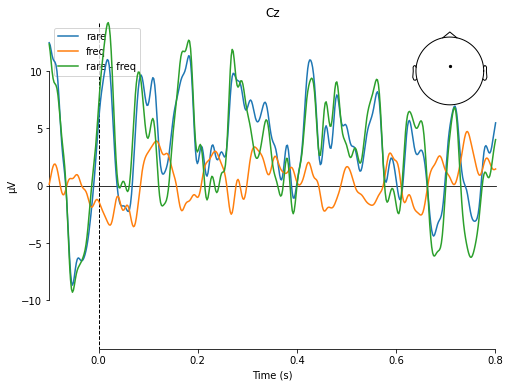

[<Figure size 576x432 with 2 Axes>]

In [20]:
mne.viz.plot_compare_evokeds({'rare': evoked_rare,'freq': evoked_freq, 'rare - freq': rare_minus_freq}, picks=["Cz"])

## It seems it is futile to check for condition on each subject since, the number of events in epochs drop downs to a range between 0,5. There is a possiblity that we might be getting futile results

## ERP Peak Analysis for all subjects

In [21]:
pipelines = MultiPipeline(bids_root)
erp = ERPAnalysis(tmin, tmax, baseline=(None, 0), reject_by_annotation=True, all_subjects=True)
pipelines.start_erp_analysis(erp);

100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


In [22]:
len(erp.epochs)

40

In [23]:
def plt_all_subjects(_epochs, ax, sub_id):
    mne.viz.plot_compare_evokeds({'rare': _epochs['rare'].average(),'freq':_epochs['freq'].average()},axes=ax, title='Subject {}'.format(sub_id), picks="Cz")

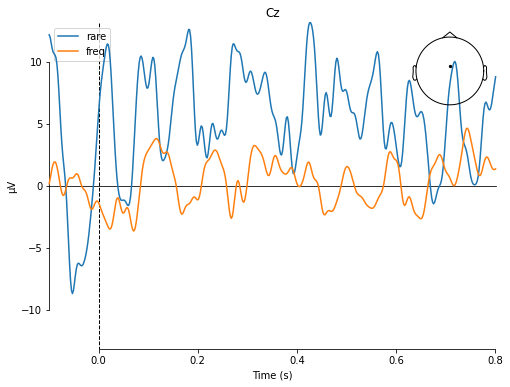

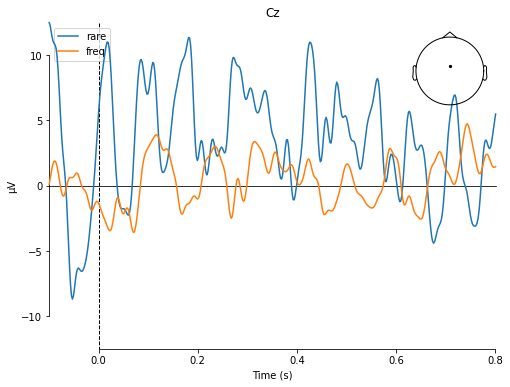

[<Figure size 576x432 with 2 Axes>]

In [24]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs[29]['rare'].average(),'freq':erp.epochs[29]['freq'].average()},picks="Cz")
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()},picks="Cz")

In [25]:
def test():
    import numpy as np
    blocks = np.array([ list(range(10*x + 1, 10*x + 6)) for x in range(1, 6)])
    rare = np.array([ x + i for i, x in enumerate(range(11, 56, 10))]).tolist()
    freq = np.setdiff1d(blocks.flatten(), rare).tolist()
    stimlus = ['A', 'B', 'C', 'D', 'E']
    evts_stim = pipeline.event_ids
    rare = [k for k in evts_stim.keys() if k.split('/')[1] == 'rare']
    freq = [k for k in evts_stim.keys() if k.split('/')[1] == 'freq']
    rare_dict = dict((k, pipeline.event_ids[k]) for k in rare)
    freq_dict = dict((k, pipeline.event_ids[k]) for k in freq)

    rare_epochs = mne.Epochs(pipeline.raw,pipeline.events, rare_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
    freq_epochs = mne.Epochs(pipeline.raw,pipeline.events, freq_dict,tmin=-0.2,tmax=0.8, reject_by_annotation=False).copy()
    mne.viz.plot_compare_evokeds({'rare': rare_epochs.average(), 'freq': freq_epochs.average()}, picks='Cz')

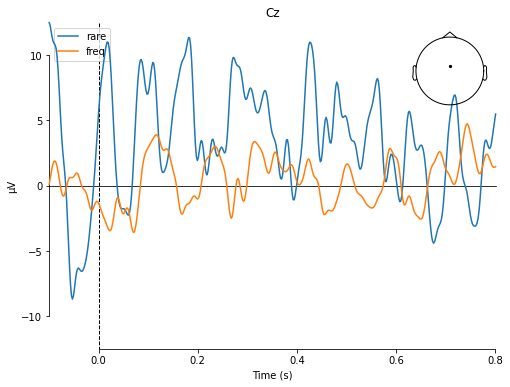

[<Figure size 576x432 with 2 Axes>]

In [26]:
mne.viz.plot_compare_evokeds({'rare': epochs_clean['rare'].average(),'freq':epochs_clean['freq'].average()},picks="Cz")

# ERP Peak Analysis

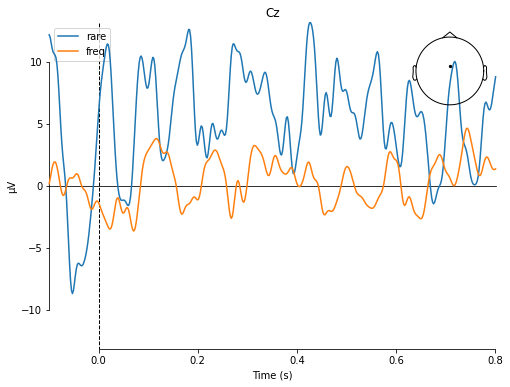

[<Figure size 576x432 with 2 Axes>]

In [27]:
mne.viz.plot_compare_evokeds({'rare': erp.epochs[29]['rare'].average(),'freq':erp.epochs[29]['freq'].average()},picks="Cz")

`rare_peaks_df` and `freq_peaks_df` contains ERP peaks of all trials

In [31]:
rare_peaks_df = erp.compute_peak('rare', 0.3, 0.1, ['Cz'], 'pos')
freq_peaks_df = erp.compute_peak('freq', 0.3, 0.1, ['Cz'], 'pos')

For example, ERP peaks for Subject 39

In [54]:
rare_peaks_df[39].describe()

peak_amp   mean_amp     latency      trial
count  17.000000  17.000000   17.000000  17.000000
mean   18.705882   4.764706  270.117647   8.000000
std    15.699382  14.398478   58.476365   5.049752
min    -9.000000 -25.000000  199.000000   0.000000
25%     6.000000  -5.000000  223.000000   4.000000
50%    16.000000   5.000000  262.000000   8.000000
75%    31.000000  14.000000  316.000000  12.000000
max    51.000000  38.000000  398.000000  16.000000

In [66]:
freq_peaks_df[39].describe()

peak_amp   mean_amp     latency      trial
count  57.000000  57.000000   57.000000  57.000000
mean   14.859649   0.017544  294.140351  28.000000
std    15.850235  15.125063   70.633723  16.598193
min   -26.000000 -46.000000  199.000000   0.000000
25%     6.000000  -7.000000  230.000000  14.000000
50%    14.000000  -1.000000  297.000000  28.000000
75%    21.000000   7.000000  365.000000  42.000000
max    67.000000  44.000000  398.000000  56.000000

## Now we will take the difference of conditions for each subject by calculating `rare_peaks_df` - `rare_peaks_df` and perform t-test

Performing t-test at individual subject level

In [102]:
from scipy import stats
dfg, peak_p_values, mean_p_values, average_rare_amplitude, average_freq_amplitude = [], [], [], [], []
for rare_df, freq_df in zip(rare_peaks_df, freq_peaks_df):
    inval_col = ['trial', 'stimulus', 'condition', 'channel']
    peak_p_values.append(stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])[1])
    mean_p_values.append(stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])[1])
    average_rare_amplitude.append(rare_df.mean()[1])
    average_freq_amplitude.append(freq_df.mean()[1])
    dfg.append(rare_df.drop(inval_col, axis=1).subtract(freq_df.drop(inval_col, axis=1)))

<AxesSubplot:ylabel='Count'>

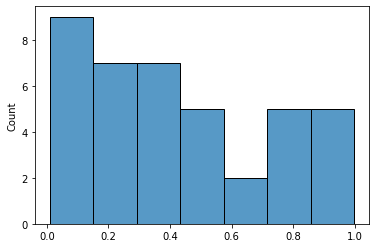

In [103]:
# _, axs = plt.subplots(nrows=1, ncols=2, figsize=(4, 3)); #doesn;t work because of %matplotlib inline
sns.histplot(peak_p_values)


<AxesSubplot:ylabel='Count'>

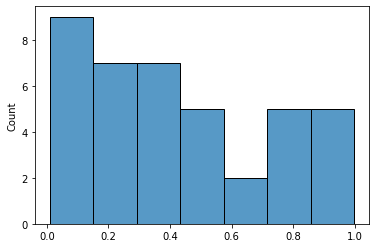

In [104]:
sns.histplot(mean_p_values)

In [105]:
dfg[39].describe()

peak_amp   mean_amp     latency
count  17.000000  17.000000   17.000000
mean    7.058824   4.705882  -17.470588
std    21.451896  20.726688   93.603631
min   -20.000000 -22.000000 -170.000000
25%    -7.000000 -12.000000  -92.000000
50%     0.000000   1.000000    0.000000
75%    21.000000  21.000000   57.000000
max    50.000000  45.000000  156.000000

T- Test for all subjects by taking average

In [106]:
# average_rare_amplitude
stats.ttest_ind(average_rare_amplitude, average_freq_amplitude)

Ttest_indResult(statistic=0.5137064307663419, pvalue=0.6089094514236308)

Well this seems incorrect! Ideally I was expecting a value less the 0.1 or 0.2

On my best day maybe a value < 0.05

But based on what we have, we can't reject the null hypothesis which is there is a significant difference between condition `rare` and `freq`

### Let's calculate T-test again without taking average

In [84]:
import pandas as pd
rare_df = pd.concat(rare_peaks_df, ignore_index=True)
freq_df = pd.concat(freq_peaks_df, ignore_index=True)
rare_df.describe()

peak_amp    mean_amp     latency       trial
count  657.000000  657.000000  657.000000  657.000000
mean    14.146119    0.196347  296.732116    8.234399
std     11.647907    9.481342   64.272107    5.405212
min    -41.000000  -63.000000  199.000000    0.000000
25%      7.000000   -5.000000  238.000000    4.000000
50%     13.000000    0.000000  295.000000    8.000000
75%     20.000000    6.000000  354.000000   13.000000
max     79.000000   40.000000  398.000000   21.000000

In [38]:
freq_df.describe()

peak_amp     mean_amp      latency        trial
count  2565.000000  2565.000000  2565.000000  2565.000000
mean     13.680702    -0.107992   301.640546    33.313060
std      11.343136     9.085980    63.322512    20.890208
min     -56.000000   -85.000000   199.000000     0.000000
25%       6.000000    -6.000000   246.000000    16.000000
50%      13.000000     0.000000   303.000000    32.000000
75%      20.000000     5.000000   357.000000    50.000000
max      84.000000    58.000000   398.000000    80.000000

### T- Test for all subjects without taking average

In [85]:
stats.ttest_ind(rare_df['mean_amp'], freq_df['mean_amp'])

Ttest_indResult(statistic=0.7591913945799333, pvalue=0.4477936442097381)

### Seems like our p-value is improved but we still don't have enough evidence to reject the Null hypothesis

In [39]:
peak_df = pd.concat([rare_df, freq_df], ignore_index=True)

## Alright, so stats has betrayed us! Let's do some plotting to see what are we missing

### Plotting only on condition: `Rare`, `Freq`

<AxesSubplot:xlabel='latency', ylabel='Density'>

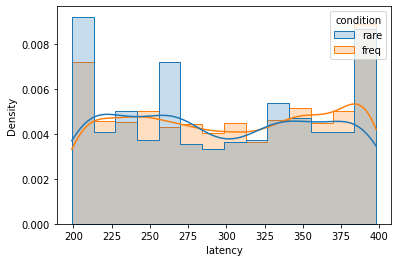

In [40]:
import seaborn as sns
sns.histplot(peak_df, x='latency', hue='condition', kde=True, element="step",
    stat="density", common_norm=False)

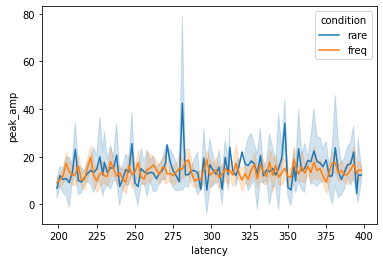

In [41]:
ax = sns.lineplot(x="latency", y="peak_amp", data=peak_df, hue='condition')

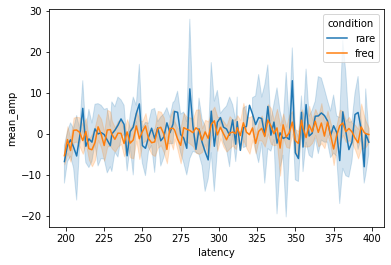

In [42]:
ax = sns.lineplot(x="latency", y="mean_amp", data=peak_df, hue='condition')

## Let's see for both condition [rare, freq] and stimulus [A, B, C, D, E]

In [123]:
A_rare_peaks = pd.concat(erp.compute_peak('A/rare', 0.4, 0.1, ['Cz']), ignore_index=True)
A_freq_peaks = pd.concat(erp.compute_peak('A/freq', 0.4, 0.1, ['Cz']), ignore_index=True)
B_rare_peaks = pd.concat(erp.compute_peak('B/rare', 0.4, 0.1, ['Cz']), ignore_index=True)
B_freq_peaks = pd.concat(erp.compute_peak('B/freq', 0.4, 0.1, ['Cz']), ignore_index=True)
C_rare_peaks = pd.concat(erp.compute_peak('C/rare', 0.4, 0.1, ['Cz']), ignore_index=True)
C_freq_peaks = pd.concat(erp.compute_peak('C/freq', 0.4, 0.1, ['Cz']), ignore_index=True)
D_rare_peaks = pd.concat(erp.compute_peak('D/rare', 0.4, 0.1, ['Cz']), ignore_index=True)
D_freq_peaks = pd.concat(erp.compute_peak('D/freq', 0.4, 0.1, ['Cz']), ignore_index=True)
E_rare_peaks = pd.concat(erp.compute_peak('E/rare', 0.4, 0.1, ['Cz']), ignore_index=True)
E_freq_peaks = pd.concat(erp.compute_peak('E/freq', 0.4, 0.1, ['Cz']), ignore_index=True)


We will contact all of them

In [133]:
all_peaks = pd.concat([
A_rare_peaks,
A_freq_peaks,
B_rare_peaks,
B_freq_peaks,
C_rare_peaks,
C_freq_peaks,
D_rare_peaks,
D_freq_peaks,
E_rare_peaks,
E_freq_peaks,
], ignore_index=True)

In [134]:
all_peaks.describe()


peak_amp     mean_amp      latency        trial
count  3222.000000  3222.000000  3222.000000  3222.000000
mean     13.680012    -0.018312   398.928305    10.166977
std      12.078691     9.760114    62.273073     8.472615
min     -62.000000   -82.000000   301.000000     0.000000
25%       6.000000    -6.000000   342.000000     3.000000
50%      13.000000     0.000000   398.000000     8.000000
75%      20.000000     6.000000   455.000000    16.000000
max      84.000000    64.000000   498.000000    31.000000

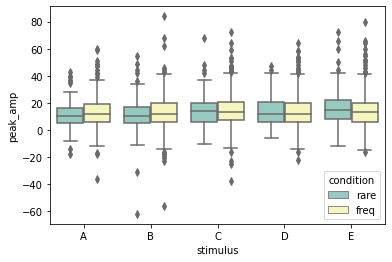

In [135]:
ax = sns.boxplot(x="stimulus", y="peak_amp", hue="condition",  data=all_peaks, palette="Set3")

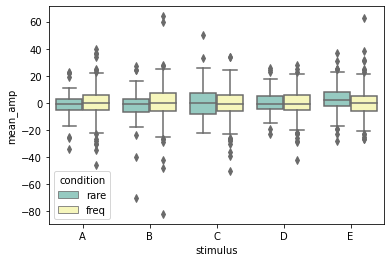

In [136]:
ax = sns.boxplot(x="stimulus", y="mean_amp", hue="condition",  data=all_peaks, palette="Set3")

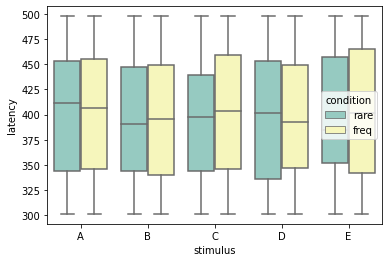

In [137]:
ax = sns.boxplot(x="stimulus", y="latency", hue="condition",  data=all_peaks, palette="Set3")

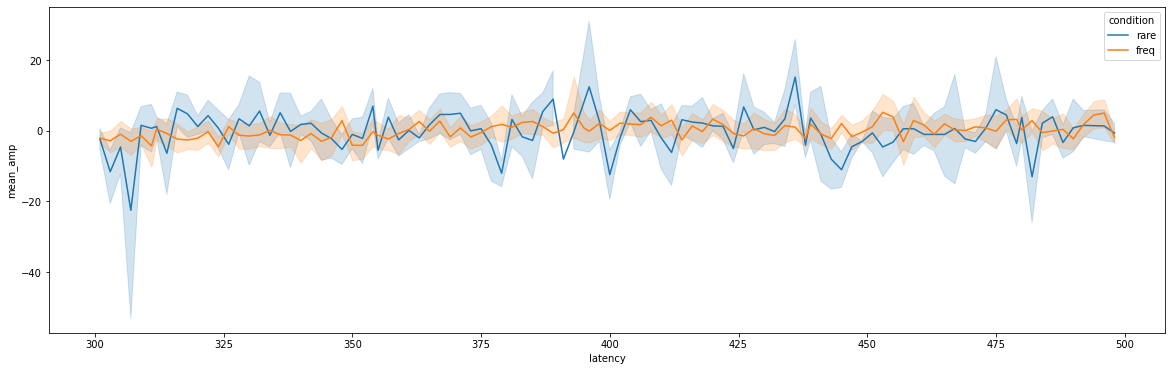

In [138]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='condition')

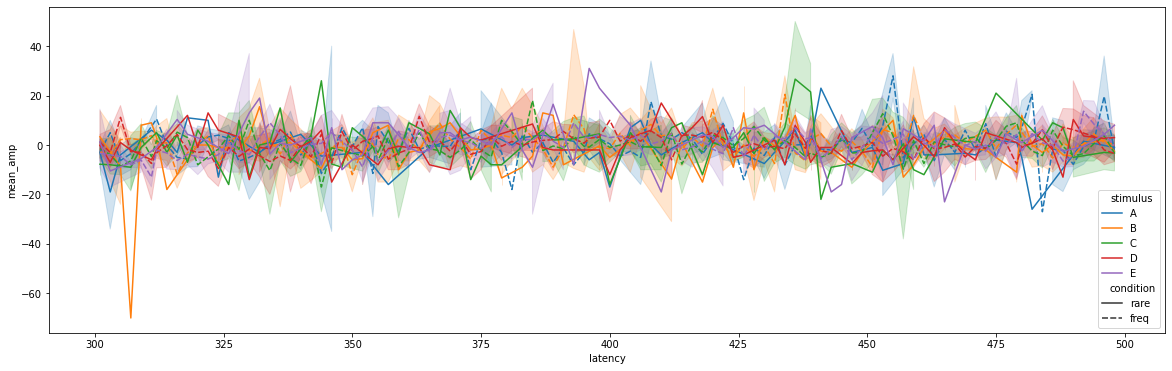

In [130]:
_, axs = plt.subplots(nrows=1, ncols=1, figsize=(20, 6));
axs = sns.lineplot(x="latency", y="mean_amp", data=all_peaks, hue='stimulus', style="condition")

<AxesSubplot:xlabel='mean_amp', ylabel='Density'>

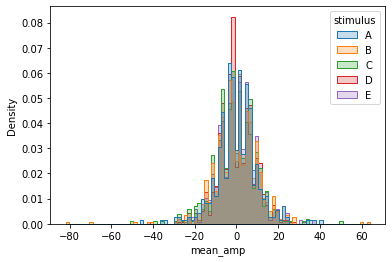

In [131]:
sns.histplot(
    all_peaks, x="mean_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)

<AxesSubplot:xlabel='peak_amp', ylabel='Density'>

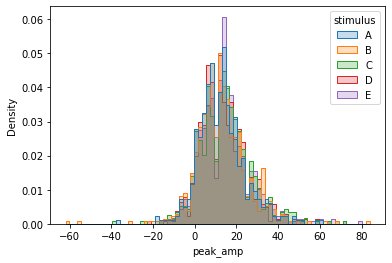

In [132]:
sns.histplot(
    all_peaks, x="peak_amp", hue="stimulus", element="step",
    stat="density", common_norm=False,
)